In [ ]:
# plots

In [12]:
library(dplyr)
library(Seurat)
library(lisi)
library(ggplot2)
library(mclust)
library(cluster)
library(RColorBrewer)
qiu_palette = c(brewer.pal(n = 7, 'Pastel1'), brewer.pal(n = 7, 'Set1'), brewer.pal(n = 7, 'Pastel2'))

In [3]:
# palettes
subs2 = c('Endocardial', 'Immature_Cardiomyocytes', 'Cardiomyocytes', 'Smooth_Muscle_Cells',  
          'Myeloid_Immune_Cells', 'Lymphoid_Immune_Cells', 'Pericytes_Stromal', 'Pericytes', 'Fibroblasts',
          'Endothelial_Arterial', 'Endothelial_Venous', 'Endothelial_Capillaries', 'Neuronal_Cells',
          'Immature_Endothelium', 'Immature_FB-like', 'Immature_Neuralcrest',
          'Epicardium_FB-like', 'Epicardium_Meso', 'Epicardium_Proliferating')

ks_palette = c('#29c5f6', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#ff9aba', '#651f7e', '#643b9f', '#358957',
            '#dce775', '#574e3c', '#84b023', '#4900e6',
           '#fc6c85', '#a94064', '#c154c1',
           '#3a9bdc', '#5579c6', '#1260cc')
ks_palette <- ks_palette[order(subs2)]

In [6]:
# load anno
tab1 = read.delim('lizard_celltype_annotations.csv', sep = ',')
tab1[1,]
tab2 = read.delim('lizard_scanorama_clusters.csv', sep = ',')
tab2[1,]

stage  sample  barcode                                     Qiu        
1 stage9 sample1 stage9_sample1_9_sample1_AAACCCAAGACCATGG-1 Endothelium
  Asp                            Hill  Mantri Feng           Knight_Schrijver 
1 Endothelium Pericytes Adventia EndoC NA     endocardial_ec Endothelial_Other
  consensus_type  
1 Endothelial_cell

X                                             clusters
1 stage9_sample1_9_sample1_AAACCCAAGACCATGG-1-0 3

In [5]:
# load data
sc1 = readRDS('stage9_integrated_cca.rds')
sc2 = readRDS('stage13_integrated_cca.rds')
sc3 = readRDS('stage16_integrated_cca.rds')

In [60]:
# add clusters, anno
cols1 = c('sample', 'dataset')

mat1 = sc1@assays$RNA@counts

sce = CreateSeuratObject(counts = cbind(mat1,
                                        sc2@assays$RNA@counts,
                                        sc3@assays$RNA@counts),
                         meta.data = rbind(sc1@meta.data[,cols1], sc2@meta.data[,cols1], sc3@meta.data[,cols1]))

sce$consensus_type = tab1$consensus_type[match(colnames(sce), tab1$barcode)]
sce$seurat_clusters = tab2$clusters[match(colnames(sce), tab1$barcode)]  # both dfs should be ordered similarly

# normalize
sce <- sce[!duplicated(rownames(sce)),]
sce <- NormalizeData(sce)

Normalizing layer: counts



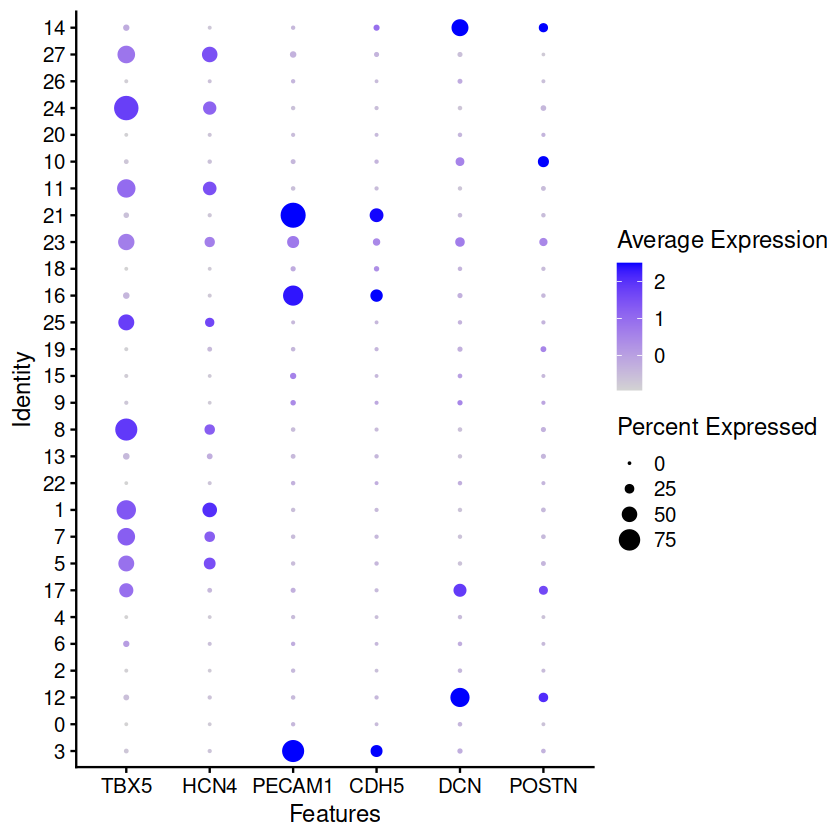

In [63]:
Idents(sce) <- 'seurat_clusters'
DotPlot(sce, features = c("TBX5", "HCN4", "PECAM1", "CDH5", "DCN", "POSTN"))

In [75]:
# load data
dfnew = read.delim('lizard_scanorama_umap.csv', sep = ',', header = F)
colnames(dfnew) = c('scanorama_umap1', 'scanorama_umap2')
sce$batch = paste0(sce$orig.ident, '_', sce$sample)
dfnew$batch = sce$batch
dfnew$celltype = sce$consensus_type
dfnew$stage = sce$orig.ident
dfnew$seurat_clusters = sce$seurat_clusters
dfnew[100:102,]

scanorama_umap1 scanorama_umap2 batch          celltype      stage 
100 11.873423       15.94017        stage9_sample1 Myeloid_cell  stage9
101  4.011304       13.80716        stage9_sample1 Cardiomyocyte stage9
102 -3.607705       15.32560        stage9_sample1 Cardiomyocyte stage9
    seurat_clusters
100 2              
101 6              
102 8

In [67]:
# LISI - batch mixing
X = as.matrix(dfnew[,c('scanorama_umap1', 'scanorama_umap2')])
meta_data = data.frame(label1 = sce$batch)  # sample
res <- compute_lisi(X, meta_data, 'label1')
median(res[,1], na.rm = T)

[1] 4.433011

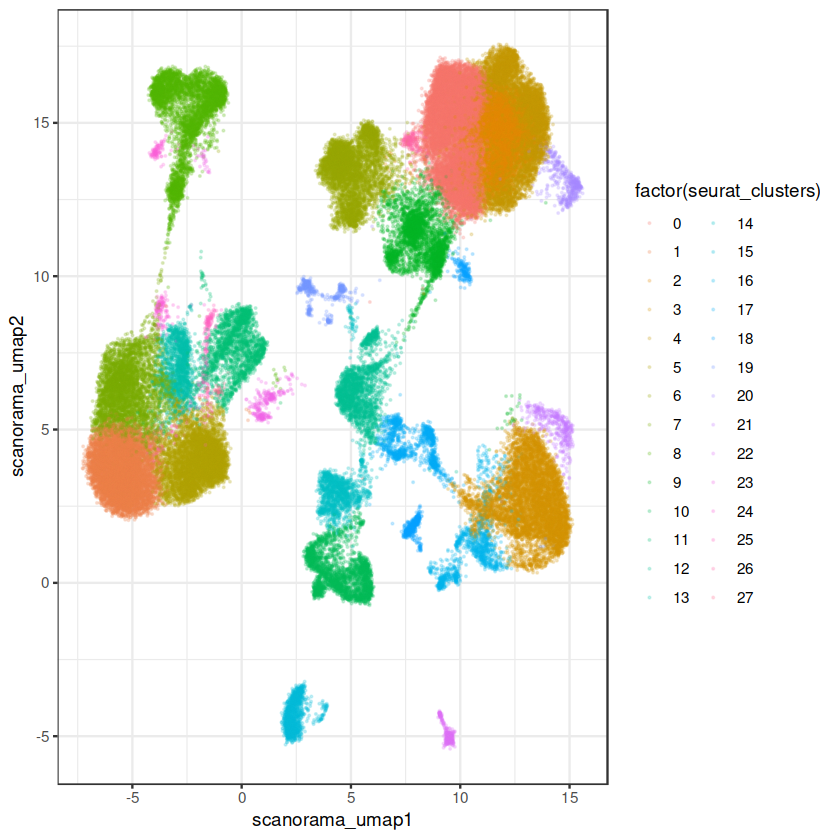

In [76]:
# png(paste0('aa-scanorama-', currstage, '.png'), width = 4, height = 4, res = 300, units = 'in')
ggplot(dfnew, aes(x = scanorama_umap1, y = scanorama_umap2)) + 
geom_point(size = 0.1, alpha = 0.2, aes(colour = factor(seurat_clusters))) + 
theme_bw() #+ scale_color_manual(values = qiu_palette) + theme(legend.position = 'none')
# guides(colour = guide_legend(override.aes = list(size=2)))
# dev.off()

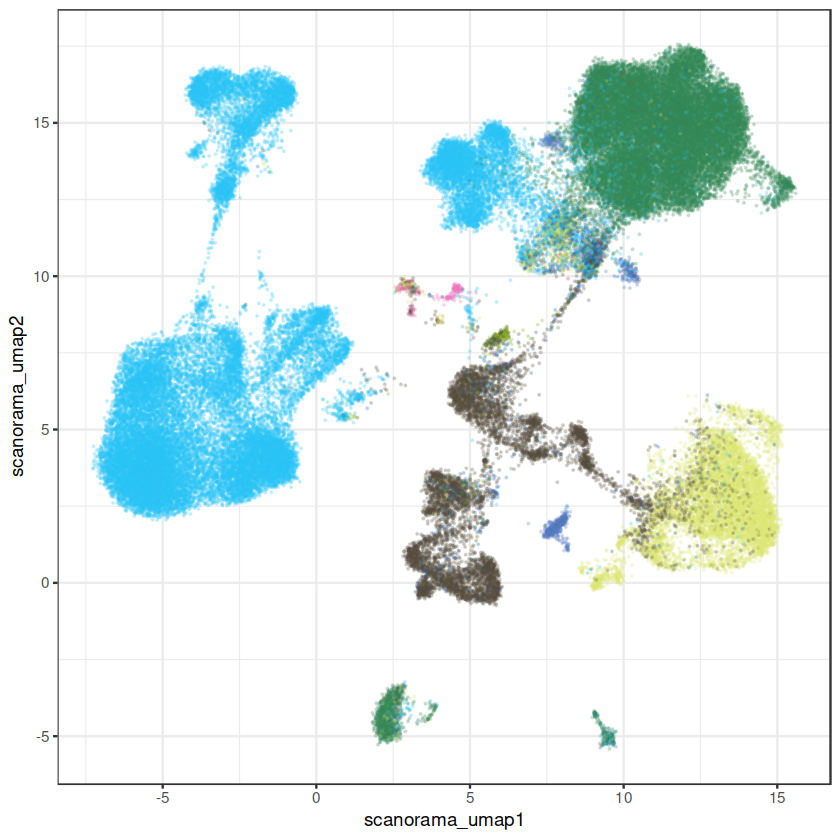

In [72]:
# png(paste0('aa-scanorama-', currstage, '.png'), width = 4, height = 4, res = 300, units = 'in')
ggplot(dfnew, aes(x = scanorama_umap1, y = scanorama_umap2)) + 
geom_point(size = 0.1, alpha = 0.2, aes(colour = factor(celltype))) + 
theme_bw() + scale_color_manual(values = ks_palette) + theme(legend.position = 'none')
# guides(colour = guide_legend(override.aes = list(size=2)))
# dev.off()